In [14]:
import discretisedfield as df
import micromagneticmodel as mm
import matplotlib.pyplot as plt
import oommfc as oc
import random
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='svg'
thickness = 2e-9
cell = (2e-9, 2e-9, 2e-9)
p1 = (-500e-9, -60e-9, -thickness/2)
p2 = (500e-9, 60e-9, thickness/2)
region=df.Region(p1=p1,p2=p2)
mesh = df.Mesh(region=region, cell=cell)
system = mm.System(name='skyrmionium_dynamics')

In [35]:
def init_skium(pos):
    x, y = pos[0], pos[1]
    if (x**2+y**2)**0.5<40e-9 and (x**2+y**2)**0.5>20e-9:
        m = (0,0,-1)
    elif (x**2+y**2)**0.5<20e-9 :
         m = (0,0,1)
    else:
        m = (0, 0, 1)
    
    return m
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + mm.Damping(alpha=0.3)
system.energy = mm.Exchange(A=1e-11)+mm.DMI(D=3.5e-3, crystalclass='Cnv_z')+mm.UniaxialAnisotropy(K=0.8e6, u=(0,0,1))+mm.Zeeman(H=(0,0,0.04/mm.consts.mu0))
system.m =  df.Field(mesh, dim=3, value=init_skium, norm=5.8e5)
ad = oc.MinDriver()
ad.drive(system)

Running OOMMF (ExeOOMMFRunner)[2022/09/21 21:54]... (8.7 s)


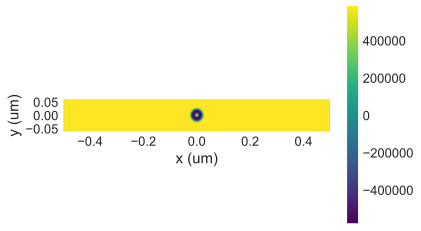

In [36]:
system.m.z.plane('z').mpl.scalar()

In [37]:
import micromagneticdata as md
data=md.Data(system.name)
data.info

,drive_number,date,time,driver
0,0,2022-09-21,21:54:20,MinDriver


In order to draw the motion track of skyrmionium, we first need to capture the center point of skyrmionium, where the center point ($x_{1}$, $y_{1}$) can be defined by the following formula：

\begin{equation}
x_1=\frac{\int x\left(1-m_z\right) d x d y}{\int\left(1-m_z\right) d x d y}, y_1=\frac{\int y\left(1-m_z\right) d x d y}{\int\left(1-m_z\right) d x d y}
\end{equation}

In ubermag, this method can be implemented with the following codes:

In [43]:
def skium_location(l,n):
    X = []
    Y = []
    for i in range(n):
        m = data[l][i].orientation
        x = df.Field(data[l][i].mesh, dim =1, value = lambda pos:pos[0])
        y = df.Field(data[l][i].mesh, dim =1, value = lambda pos:pos[1])
        Rx = df.integral(x * (1-m.z) * df.dx * df.dy) / df.integral((1-m.z) * df.dx * df.dy)
        Ry = df.integral(y * (1-m.z) * df.dx * df.dy) / df.integral((1-m.z) * df.dx * df.dy)
        X.append(Rx)
        Y.append(Ry)
    return X,Y

In [50]:
center_point=(skium_location(0,1)[0],skium_location(0,1)[1])
print(center_point)

([1.9187221547775284e-20], [4.815144731685832e-20])
